In [15]:
!python3.11 -m pip install --upgrade pip
!pip install ninja
!pip install diffusers transformers accelerate scipy opencv-python

/bin/bash: line 1: python3.11: command not found


In [16]:
import torch
import PIL, cv2
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt
import numpy as np
import copy

In [17]:
!pip install torchvision
import torch

In [18]:
!pip install torch
!pip install torchvision

In [19]:
import torchvision.transforms as transforms

  Preparing metadata (setup.py) ... done
Cloning into 'clipseg'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 232 (delta 72), reused 57 (delta 57), pack-reused 148
Receiving objects: 100% (232/232), 1.40 MiB | 6.67 MiB/s, done.
Resolving deltas: 100% (126/126), done.
/content/clipseg/clipseg/clipseg/clipseg/clipseg/clipseg/clipseg/clipseg/clipseg
--2024-07-31 01:12:47--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [              <=>   ]   9.68M  3.48MB/s    in 2.8s    

2024-07-31 01:12:51 (3.48 MB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
 extracting: weights/rd16-uni.pth 

<ipython-input-20-58d0410ccd6c>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cpu')),

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Saving image.jpg to image.jpg
Source image size: (3923, 5811)
Target image size: (512, 512)


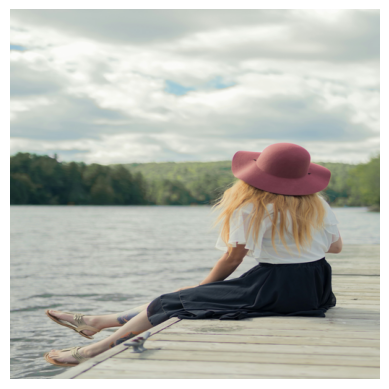

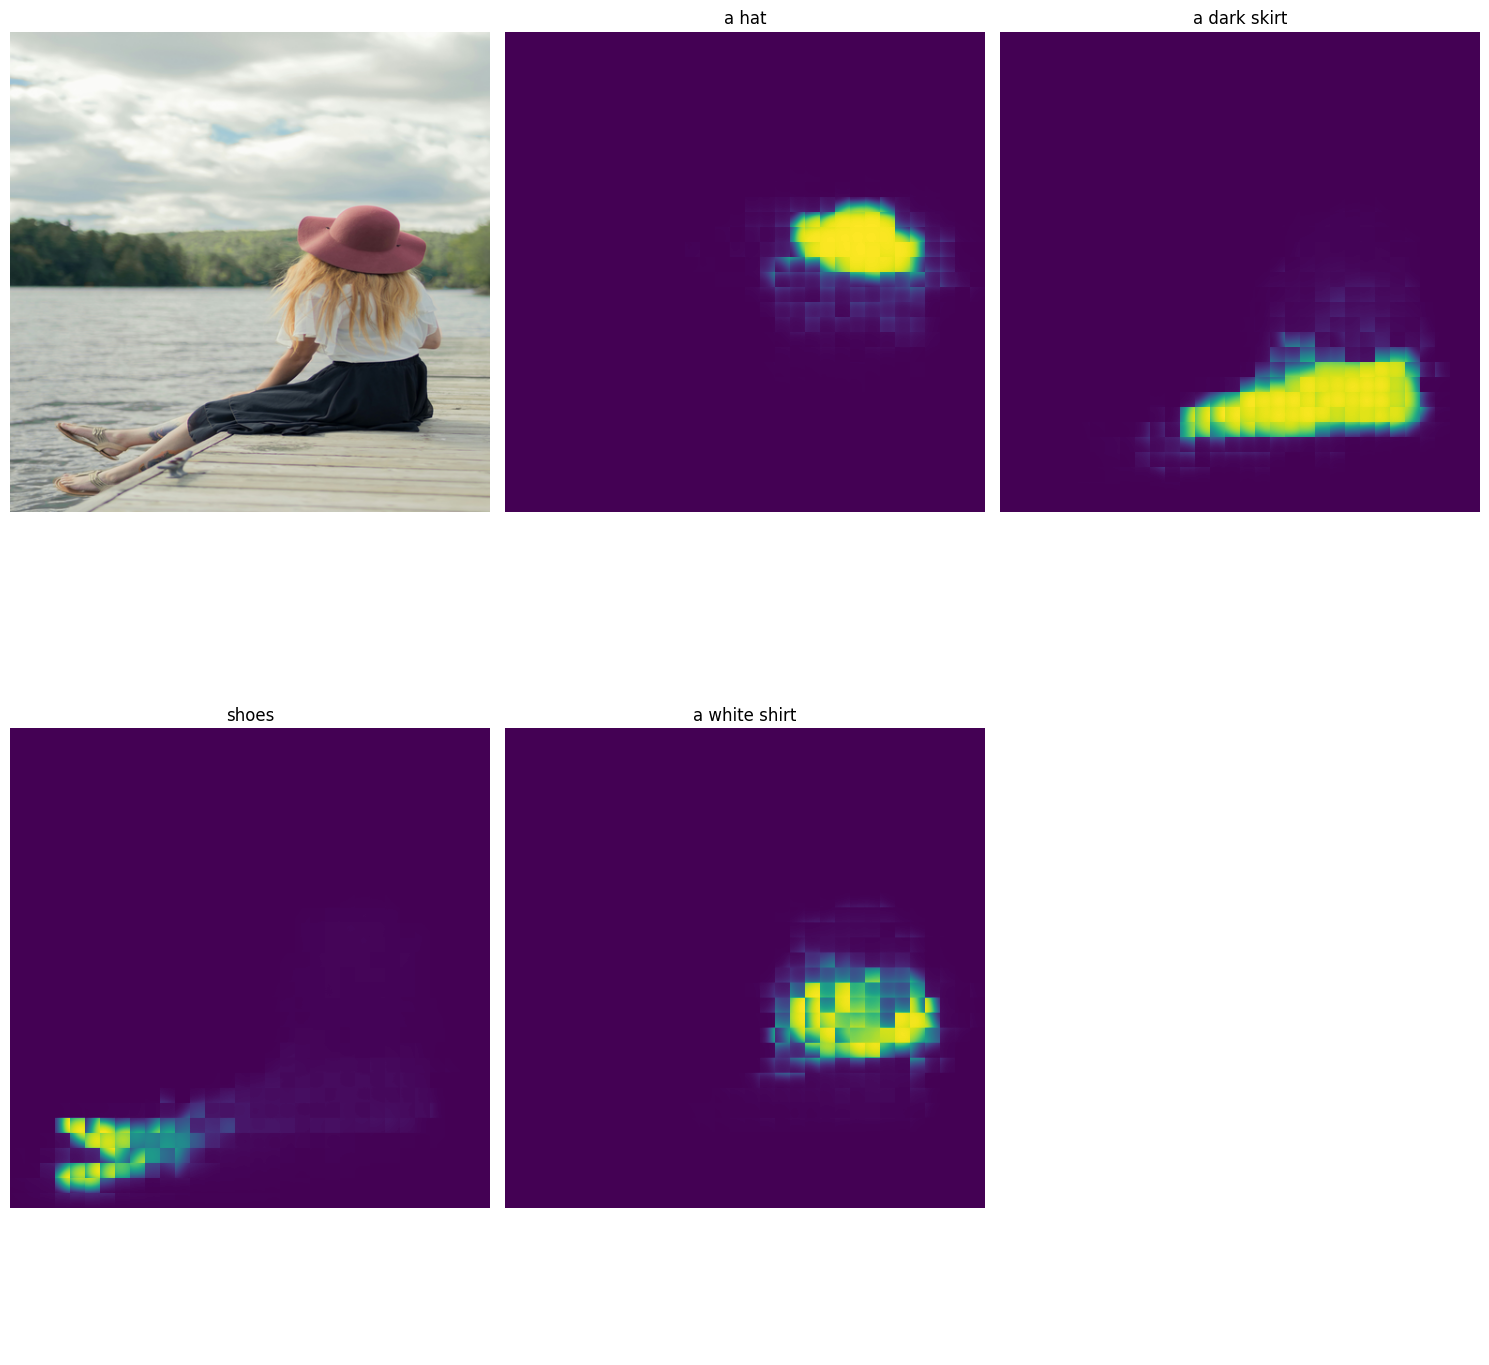

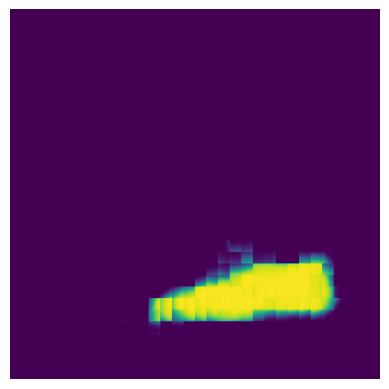

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

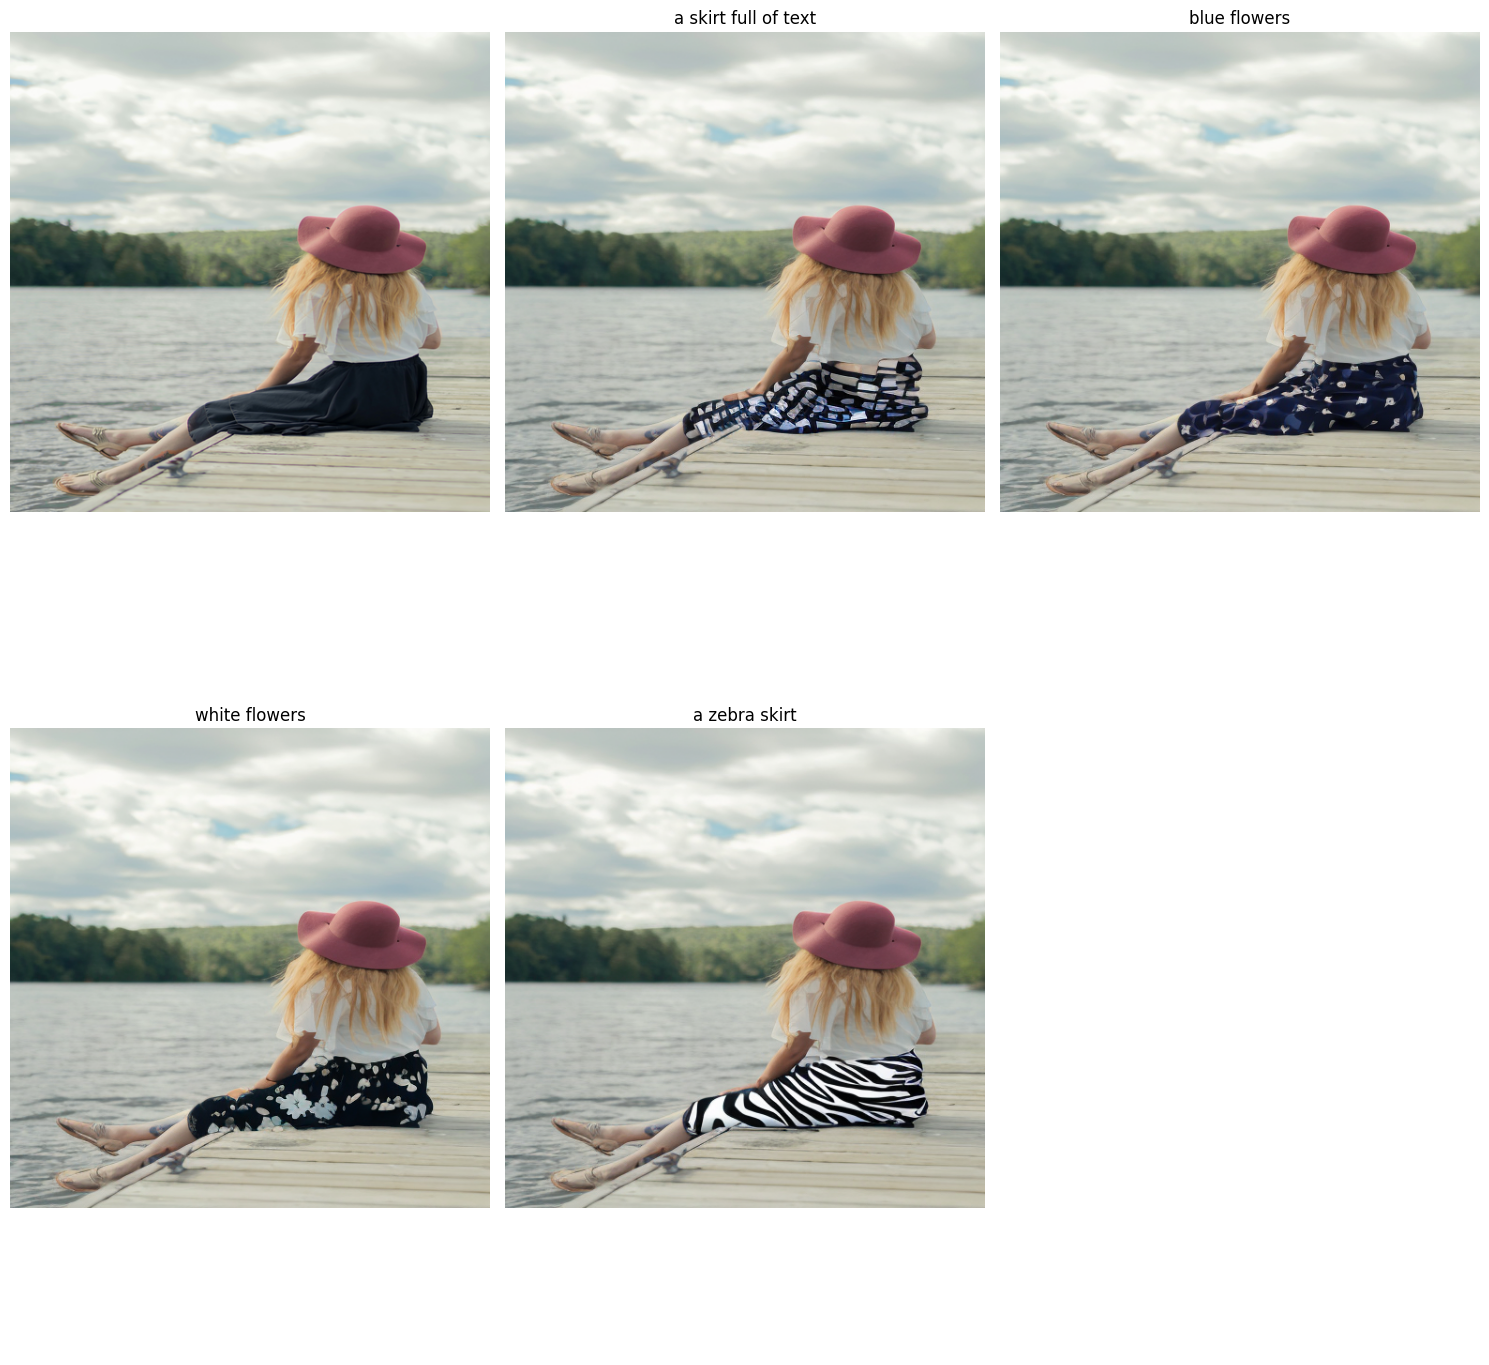

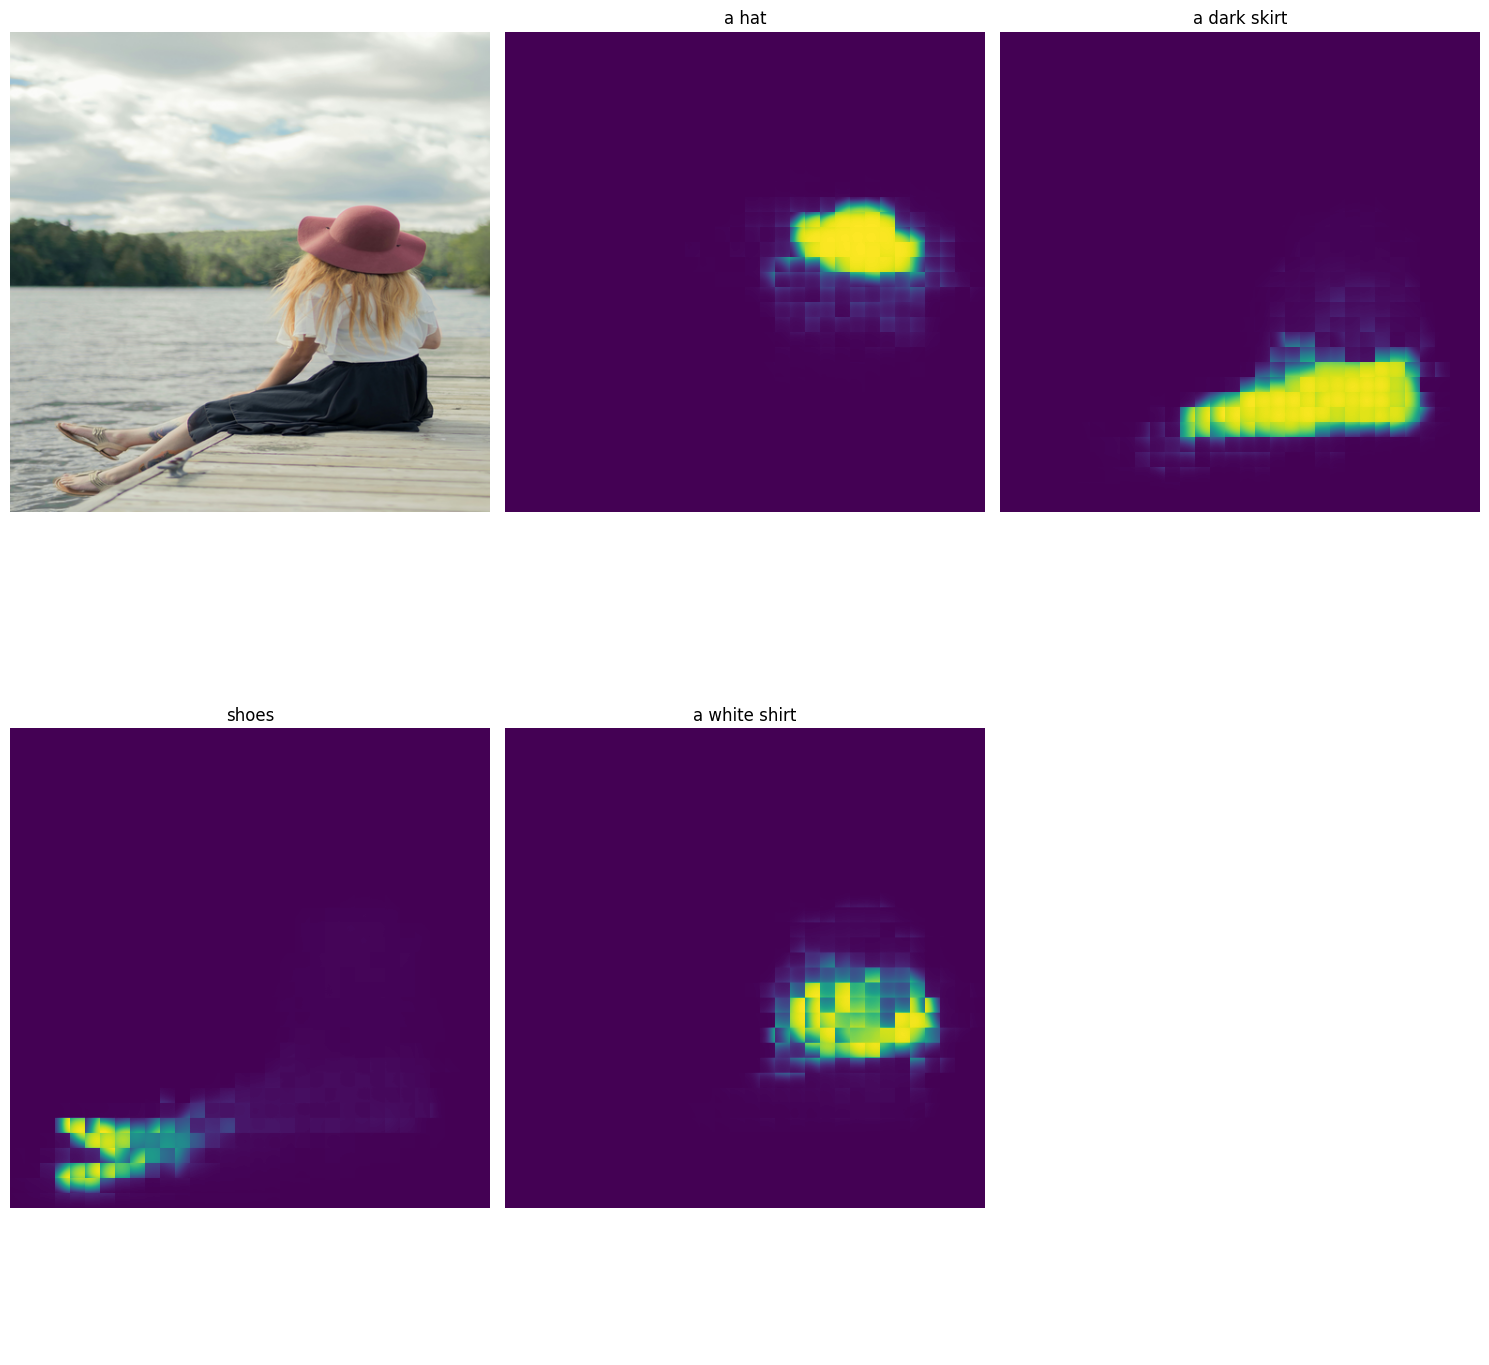

In [20]:
!pip install -q git+https://github.com/openai/CLIP.git
!git clone https://github.com/timojl/clipseg
%cd clipseg
!wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
!unzip -d weights -j weights.zip

import clip
from models.clipseg import CLIPDensePredT

model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval()

model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False)

### imp Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir = "stabilityai/stable-diffusion-2-inpainting"

scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                      scheduler=scheduler,
                                                      revision="fp16",
                                                      torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

from google.colab import files
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
from torchvision.transforms.functional import to_pil_image

uploaded = files.upload()

filename = next(iter(uploaded))

source_image = Image.open(io.BytesIO(uploaded[filename]))

target_width, target_height = 512, 512
width, height = source_image.size
print(f"Source image size: {source_image.size}")

source_image = source_image.resize((target_width, target_height), Image.LANCZOS)
print(f"Target image size: {source_image.size}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tensor_image = transform(source_image).unsqueeze(0)

plt.imshow(source_image)
plt.axis('off')
plt.show()


# Create masks for the parts of the clothes to be identified

#################### DO PROMPT ENGINEERING WHAT YOU WANT TO CHANGE STARTS #####################
prompts = ['a hat', 'a dark skirt', 'shoes', 'a white shirt']
#################### DO PROMPT ENGINEERING WHAT YOU WANT TO CHANGE ENDS #######################

with torch.no_grad():
    preds = model(tensor_image.repeat(len(prompts), 1, 1, 1), prompts)[0]

def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)
    images = copy.copy(images)

    if torch.is_tensor(images):
        assert images.size(0) == len(names), "Number of images and names should be equal"

        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        assert len(images) == len(names), "Number of images and names should be equal"

    total_images = len(images) + 1
    if total_images < rows * columns:
        rows = (total_images + columns - 1) // columns
        columns = (total_images + rows - 1) // rows

    images.insert(0, original_image)

    names.insert(0, '')

    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    for idx, (img, name) in enumerate(zip(images, names)):
        row, col = divmod(idx, columns)

        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        axes[row, col].set_title(name)

        axes[row, col].axis('off')

    for idx in range(len(images), rows * columns):
        row, col = divmod(idx, columns)
        axes[row, col].axis('off')

    plt.tight_layout()

    plt.show()


create_image_grid(source_image, preds, prompts, 2, 3)

mask_number = 1

processed_mask = torch.special.ndtr(preds[mask_number][0])

stable_diffusion_mask = transforms.ToPILImage()(processed_mask)
plt.imshow(stable_diffusion_mask)
plt.axis('off')
plt.show()

num_images_per_prompt = 4
inpainting_prompts = ["a skirt full of text",  "blue flowers", "white flowers", "a zebra skirt"]

generator = torch.Generator(device="cuda").manual_seed(77)  # 155, 77

encoded_images = []
for i in range(num_images_per_prompt):
    image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
    encoded_images.append(image)

create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)

def create_image_plus_masks_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)
    images = copy.copy(images)
    if torch.is_tensor(images):
        assert images.size(0) == len(names), "Number of images and names should be equal"
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        assert len(images) == len(names), "Number of images and names should be equal"

    total_images = len(images) + 1
    if total_images < rows * columns:
        rows = (total_images + columns - 1) // columns
        columns = (total_images + rows - 1) // rows

    images.insert(0, original_image)

    names.insert(0, '')

    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    for idx, (img, name) in enumerate(zip(images, names)):
        row, col = divmod(idx, columns)

        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        axes[row, col].set_title(name)

        axes[row, col].axis('off')

    for idx in range(len(images), rows * columns):
        row, col = divmod(idx, columns)

        axes[row, col].axis('off')

    plt.tight_layout()

    plt.show()


create_image_plus_masks_grid(source_image, preds, prompts, 2, 3)
